# 03a05 At Only -- NFD features

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import pickle 
import time 

from scipy import stats

from xgboost import XGBClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
# from sklearn.inspection import permutation_importance

import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="white")

from collections import Counter

import sys; sys.path.insert(0, '..') # add parent folder path where lib folder is
from atbotml.custom_fuctions import *

## Notebook parameters

In [2]:
nb_id = f'03a05'
nb_long_id = f'{nb_id}_At_nfd'
num_classes = 10
random_state = 42

## Load data

In [3]:
# load complete training dataframe
df = pd.read_pickle("./01_AtBot_data.pkl")
print(f"Number of data samples: {len(df)}")
print(f"Number of features: {len(df.columns)-6}")

# extract feature names from RNASeq data
gene_names = list(df)[6:29107]

# Arabidopsis only feature gene set
n_At = 20340
At_list = gene_names[0:n_At]
print(f"Number of At genes: {n_At}")
df

Number of data samples: 1092
Number of features: 29101
Number of At genes: 20340


,Index,LibraryID,HostGenoType,Sample,Isolate,Lesion,AT1G01010,AT1G01040,AT1G01046,AT1G01050,...,BCIN18G00020,BCIN18G00060,BCIN18G00145,BCIN18G00180,BCIN18G00190,EFBCT00000013145,EFBCT00000013262,EFBCT00000013292,ENSRNA049512921.T1,ENSRNA049513883.T1
0,coi1_1,coi.1.G1E.1,coi1,1,1.01.01,36.590004,39.556340,0.000000,0.000000,21.373592,...,0.0,0.000000,0.000000,0.000000,0.000000,12.438875,0.000000,0.000000,0.000000,5.321551
1,coi1_1,coi.1.G1F.1,coi1,1,1.01.01,36.590004,16.918722,0.000000,0.000000,119.029216,...,0.0,0.000000,0.000000,0.000000,0.000000,15.521645,0.000000,0.000000,0.000000,0.000000
2,coi1_1,coi.1.G2F.1,coi1,1,1.01.01,36.590004,14.735361,0.000000,0.000000,58.388002,...,0.0,0.000000,0.000000,0.000000,0.000000,76.250891,0.000000,0.000000,0.000000,0.000000
3,coi1_1,coi.1.G2E.1,coi1,1,1.01.01,36.590004,10.552052,0.000000,1.000161,19.548414,...,0.0,0.000000,0.000000,0.000000,0.000000,41.388120,73.847835,53.937879,0.000000,5.059001
4,coi1_10,coi.1.G2E.10,coi1,10,1.02.04,36.418731,15.229003,0.000000,0.000000,99.136624,...,0.0,15.577566,32.042486,0.000000,24.233666,47.555802,0.000000,54.228767,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1087,npr1_97,npr.1.G1F.972,npr1,97,1.05.16,20.747628,4.210585,0.226497,0.000000,88.664582,...,0.0,4.623277,12.227030,3.334425,16.953341,12.097817,0.000000,13.795366,0.000000,0.000000
1088,npr1_97,npr.1.G2E.971,npr1,97,1.05.16,20.747628,3.895372,0.000000,0.000000,18.900222,...,0.0,5.101576,16.951453,7.924833,14.651827,48.519908,11.222415,24.590291,1.537600,0.000000
1089,npr1_97,npr.1.G2E.972,npr1,97,1.05.16,20.747628,7.494782,0.000000,0.000000,14.318503,...,0.0,7.547289,19.236880,3.313311,15.314539,42.074248,18.768019,27.416028,0.642859,3.857151
1090,npr1_97,npr.1.G2F.971,npr1,97,1.05.16,20.747628,1.965208,0.000000,0.000000,23.361068,...,0.0,1.803102,16.690115,4.551550,37.868097,132.109896,103.127734,0.000000,0.000000,0.000000


### Features list

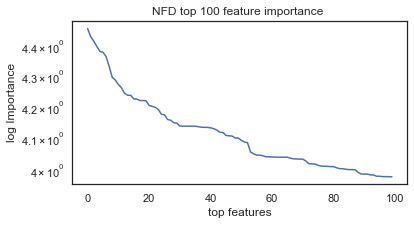

Number of selected features: 100


In [4]:
filename = "../results/03_At/features/03a_At_nfd_0.8.npy"
feature_title = "NFD"
topN = 100 #3000 #100 

features = load_feature_dict(filename, topN, show_plot=True, feature_title=feature_title)
features_list = list(features)[0:topN]
print(f'Number of selected features: {len(features_list)}')

In [5]:
# save features
df_fs = pd.DataFrame(features_list) 
df_fs.to_csv(f"../results/03_At/features/{nb_long_id}_list_{topN}.csv", header=False, index=False)

In [5]:
# load training, validation data
f = open("01_train_test_data.pkl", 'rb')
train_test_data = pickle.load(f)
f.close()

df_X_train = train_test_data['df_X_train']
df_X_train = df_X_train.loc[:,features_list]

df_X_test = train_test_data['df_X_test']
df_X_test = df_X_test.loc[:,features_list]

y_train = train_test_data['y_train']
y_test = train_test_data['y_test']
scaler = train_test_data['scaler']

print(f"Training and validation sets")
print(f"X_train: {np.shape(df_X_train)}")
print(f"X_test: {np.shape(df_X_test)}")
print(f"y_train: {np.shape(y_train)}")
print(f"y_test: {np.shape(y_test)}")

# At Only test data
f = open("01_At_test_data.pkl", 'rb')
df_At_X_test_scaled = pickle.load(f)
f.close()

df_At_X_test_scaled = df_At_X_test_scaled.loc[:,features_list]

print(f"\nTest set")
print(f"At_X_test_scaled: {np.shape(df_At_X_test_scaled)}")

# At-Psy test data
f = open("01_AtPsy_test_data.pkl", 'rb')
df_AtPsy_X_test_scaled = pickle.load(f)
f.close()

df_AtPsy_X_test_scaled = df_AtPsy_X_test_scaled.loc[:,features_list]

print(f"\nAtPsy Test set")
print(f"At_X_test_scaled: {np.shape(df_AtPsy_X_test_scaled)}")

X_train = df_X_train.to_numpy()
X_test = df_X_test.to_numpy()
At_X_test_scaled = df_At_X_test_scaled.to_numpy()
AtPsy_X_test_scaled = df_AtPsy_X_test_scaled.to_numpy()

Training and validation sets
X_train: (2060, 100)
X_test: (328, 100)
y_train: (2060,)
y_test: (328,)

Test set
At_X_test_scaled: (6, 100)

AtPsy Test set
At_X_test_scaled: (100, 100)


In [6]:
X_train = df_X_train.to_numpy()
X_test = df_X_test.to_numpy()
At_X_test_scaled = df_At_X_test_scaled.to_numpy()

## DNN

Classification accuracy is almost universally inappropriate for imbalanced classification.

For imbalanced classification problems, the *majority class* is typically referred to as the negative outcome (e.g. such as “no change” or “negative test result“), and the *minority class* is typically referred to as the positive outcome (e.g. “change” or “positive test result“).

**Sensitivity-Specificity Metrics** <br>
Sensitivity = TruePositive / (TruePositive + FalseNegative) *<br>
Specificity = TrueNegative / (FalsePositive + TrueNegative) <br>
G-Mean = sqrt(Sensitivity * Specificity)<br>




**Precision-Recall Metrics**<br>
Precision = TruePositive / (TruePositive + FalsePositive)<br>
Recall = TruePositive / (TruePositive + FalseNegative)<br>
F-Measure = (2 * Precision * Recall) / (Precision + Recall) *

### Train

In [7]:
model, history = train_dnn_1layer(X_train, y_train, X_test, y_test, num_classes, epochs=50)

Epoch 1/50
65/65 [==============================] - 1s 9ms/step - loss: 2.1308 - sparse_categorical_accuracy: 0.2521 - val_loss: 2.0908 - val_sparse_categorical_accuracy: 0.2378
Epoch 2/50
65/65 [==============================] - 0s 1ms/step - loss: 1.4878 - sparse_categorical_accuracy: 0.4883 - val_loss: 2.0904 - val_sparse_categorical_accuracy: 0.1982
Epoch 3/50
65/65 [==============================] - 0s 1ms/step - loss: 1.2352 - sparse_categorical_accuracy: 0.5762 - val_loss: 2.0414 - val_sparse_categorical_accuracy: 0.2500
Epoch 4/50
65/65 [==============================] - 0s 1ms/step - loss: 1.1172 - sparse_categorical_accuracy: 0.6136 - val_loss: 2.0378 - val_sparse_categorical_accuracy: 0.2774
Epoch 5/50
65/65 [==============================] - 0s 1ms/step - loss: 1.0375 - sparse_categorical_accuracy: 0.6500 - val_loss: 2.1504 - val_sparse_categorical_accuracy: 0.2561
Epoch 6/50
65/65 [==============================] - 0s 1ms/step - loss: 0.9457 - sparse_categorical_accuracy: 

### Test1

Accuracy:	 27.44%
Precision:	 18.10%
Recall:		 18.72%
F1 score:	 18.26%
INFO:tensorflow:Assets written to: ./models/03a05_At_nfd_dnn_model_f100/assets
Written to: ./models/03a05_At_nfd_dnn_results_f100.pkl


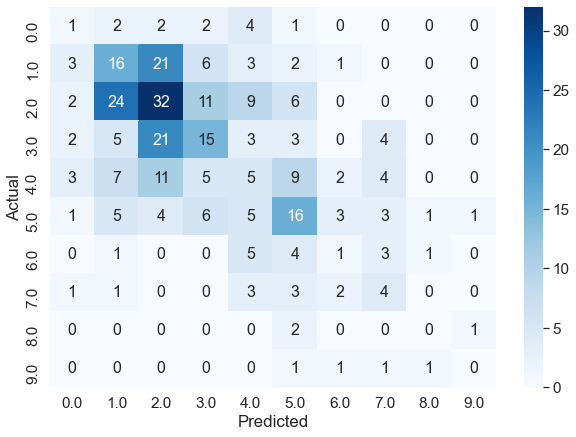

In [8]:
# Evaluate performance on Test set1
predictions = model.predict(X_test)
dnn_y_pred = np.argmax(predictions, 1)
dnn_score = get_sk_metrics(y_test, dnn_y_pred)
dnn_cm = plot_confusion_matrix(y_test, dnn_y_pred)

# save the keras model and results
filename = f"./models/{nb_long_id}_dnn_model_f{topN}"
model.save(filename)

filename = f"./models/{nb_long_id}_dnn_results_f{topN}.pkl"
pickle.dump([history.history, dnn_score, dnn_cm], open(filename, 'wb'))
print(f"Written to: {filename}")

### Test2

In [9]:
# Evaluate performance on Test set2
predictions = model.predict(At_X_test_scaled)
dnn_y_pred = np.argmax(predictions, 1)

filename = f"../results/03_At/prediction/{nb_long_id}_dnn_test_predict_f{topN}.pkl"
pickle.dump(dnn_y_pred, open(filename, 'wb'))
print(f"Written to: {filename}")

dnn_y_pred

Written to: ../results/03_At/prediction/03a05_At_nfd_dnn_test_predict_f100.pkl


array([4, 1, 1, 5, 5, 5])

### Test3 AtPsy

./models/03a05_At_nfd_dnn_model_f100
Accuracy:	 27.44%
Precision:	 18.10%
Recall:		 18.72%
F1 score:	 18.26%


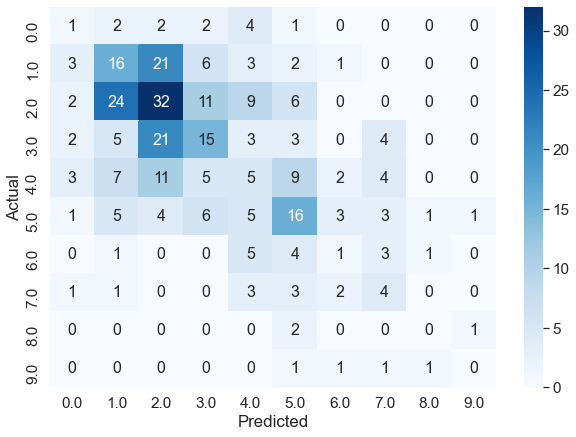

In [10]:
# load model and results
filename = f'./models/{nb_long_id}_dnn_model_f{topN}'
print(filename)
model = keras.models.load_model(filename)

filename = f'./models/{nb_long_id}_dnn_results_f{topN}.pkl'
# history, dnn_score, dnn_cm = pickle.load(open(filename,'rb'))

predictions = model.predict(X_test)
dnn_y_pred = np.argmax(predictions, 1)
dnn_score = get_sk_metrics(y_test, dnn_y_pred)
dnn_cm = plot_confusion_matrix(y_test, dnn_y_pred)

In [11]:
# Evaluate performance on Test set2

X_test_scaled = AtPsy_X_test_scaled

predictions = model.predict(X_test_scaled)
dnn_y_pred = np.argmax(predictions, 1)

filename = f"../results/03_At/prediction/{nb_long_id}_dnn_test_AtPsy_predict_f{topN}.pkl"
pickle.dump(dnn_y_pred, open(filename, 'wb'))
print(f"Written to: {filename}")

dnn_y_pred

Written to: ../results/03_At/prediction/03a05_At_nfd_dnn_test_AtPsy_predict_f100.pkl


array([5, 4, 4, 2, 5, 5, 5, 6, 0, 0, 0, 0, 5, 5, 5, 0, 0, 0, 0, 0, 5, 5,
       5, 0, 2, 2, 2, 2, 5, 5, 5, 4, 5, 6, 2, 2, 4, 2, 4, 5, 5, 4, 4, 2,
       4, 5, 5, 4, 4, 2, 0, 2, 5, 5, 5, 5, 5, 5, 4, 5, 4, 5, 4, 4, 6, 5,
       5, 0, 6, 5, 5, 4, 6, 5, 5, 4, 5, 5, 5, 4, 5, 6, 4, 5, 5, 6, 2, 2,
       2, 5, 5, 0, 2, 2, 5, 5, 4, 4, 5, 5])

## XGBoost
XGBoost is an implementation of gradient boosted decision trees designed for speed and performance.

### Train

In [12]:
xgb = XGBClassifier()

t0 = time.time()
xgb.fit(X_train, y_train)
t = time.time() - t0

print(f"\nelapsed time: {(t/60):.2f} mins")
print()

[09:35:22] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



elapsed time: 0.04 mins



### Test1

Accuracy:	 26.83%
Precision:	 17.67%
Recall:		 17.60%
F1 score:	 17.25%
Written to: ./models/03a05_At_nfd_xgb_model_results_f100.pkl


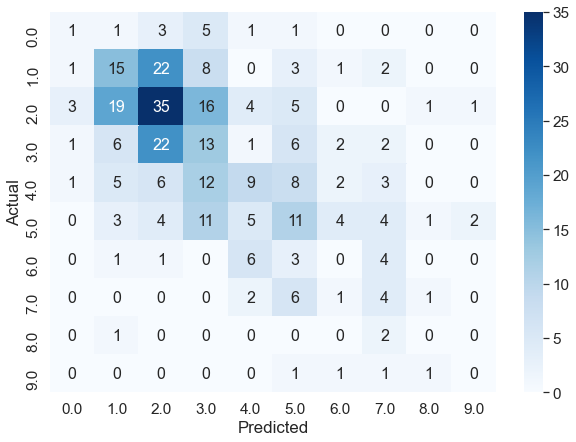

In [13]:
xgb_y_pred = xgb.predict(X_test)
xgb_score = get_sk_metrics(y_test, xgb_y_pred, average='macro')
xgb_cm = plot_confusion_matrix(y_test, xgb_y_pred)

filename = f"./models/{nb_long_id}_xgb_model_results_f{topN}.pkl"
pickle.dump([xgb, xgb_score, xgb_cm], open(filename, 'wb'))
print(f"Written to: {filename}")

### Test2

In [14]:
xgb_y_pred = xgb.predict(At_X_test_scaled)

filename = f"../results/03_At/prediction/{nb_long_id}_xgb_test_predict_f{topN}.pkl"
pickle.dump(xgb_y_pred, open(filename, 'wb'))
print(f"Written to: {filename}")
xgb_y_pred

Written to: ../results/03_At/prediction/03a05_At_nfd_xgb_test_predict_f100.pkl


array([2., 2., 2., 2., 2., 2.])

### Test3 AtPsy

./models/03a05_At_nfd_xgb_model_results_f100.pkl
Accuracy:	 26.83%
Precision:	 17.67%
Recall:		 17.60%
F1 score:	 17.25%


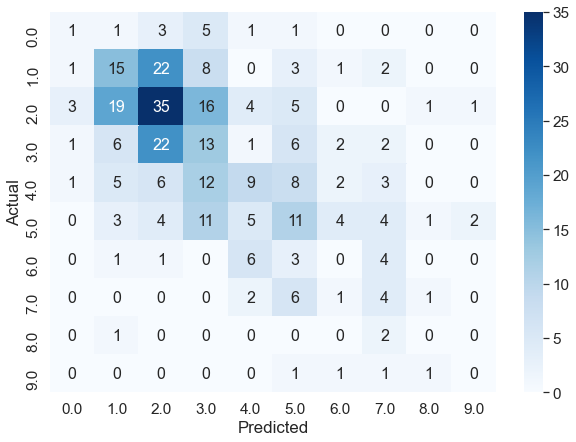

In [15]:
filename = f'./models/{nb_long_id}_xgb_model_results_f{topN}.pkl'
print(filename)
xgb, xgb_score, xgb_cm = pickle.load(open(filename,'rb'))

xgb_y_pred = xgb.predict(X_test)
xgb_score = get_sk_metrics(y_test, xgb_y_pred, average='macro')
xgb_cm = plot_confusion_matrix(y_test, xgb_y_pred)

In [16]:
X_test_scaled = AtPsy_X_test_scaled

xgb_y_pred = xgb.predict(X_test_scaled)

filename = f"../results/03_At/prediction/{nb_long_id}_xgb_test_AtPsy_predict_f{topN}.pkl"
pickle.dump(xgb_y_pred, open(filename, 'wb'))
print(f"Written to: {filename}")
xgb_y_pred

Written to: ../results/03_At/prediction/03a05_At_nfd_xgb_test_AtPsy_predict_f100.pkl


array([2., 2., 2., 2., 2., 2., 2., 2., 4., 2., 4., 4., 5., 2., 2., 4., 6.,
       2., 4., 2., 2., 8., 5., 6., 2., 2., 6., 6., 2., 2., 2., 2., 2., 6.,
       2., 2., 6., 2., 2., 2., 4., 2., 2., 6., 2., 2., 2., 2., 2., 2., 4.,
       6., 2., 6., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 5., 2., 2., 3.,
       2., 2., 2., 2., 2., 2., 6., 2., 2., 2., 2., 2., 2., 6., 2., 2., 2.,
       6., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.])

## Random Forest

### Train

In [17]:
rf = RandomForestClassifier(n_estimators=100, max_depth=30, random_state=0)

t0 = time.time()
rf.fit(X_train, y_train)
t = time.time() - t0

print(f"\nelapsed time: {(t/60):.2f} mins")
print()


elapsed time: 0.02 mins



### Test1

Accuracy:	 29.88%
Precision:	 23.99%
Recall:		 25.45%
F1 score:	 24.10%
Written to: ./models/03a05_At_nfd_rf_model_results_f100.pkl


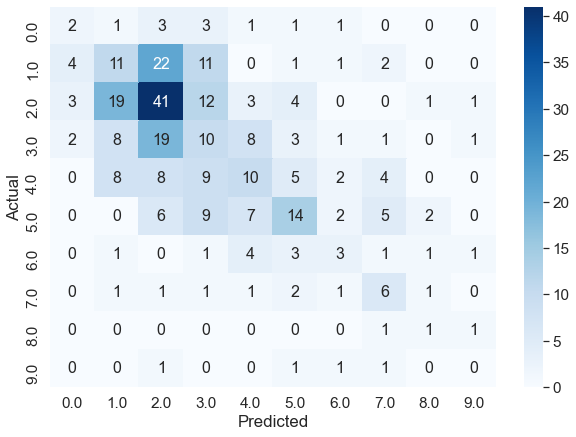

In [18]:
rf_y_pred = rf.predict(X_test)
rf_score = get_sk_metrics(y_test, rf_y_pred, average='macro')
rf_cm = plot_confusion_matrix(y_test, rf_y_pred)

filename = f"./models/{nb_long_id}_rf_model_results_f{topN}.pkl"
pickle.dump([rf, rf_score, rf_cm], open(filename, 'wb'))
print(f"Written to: {filename}")

### Test2

In [19]:
rf_y_pred = rf.predict(At_X_test_scaled)

filename = f"../results/03_At/prediction/{nb_long_id}_rf_test_predict_f{topN}.pkl"
pickle.dump(rf_y_pred, open(filename, 'wb'))
print(f"Written to: {filename}")
rf_y_pred

Written to: ../results/03_At/prediction/03a05_At_nfd_rf_test_predict_f100.pkl


array([2., 4., 2., 5., 5., 5.])

### Test3 AtPsy

./models/03a05_At_nfd_rf_model_results_f100.pkl
Accuracy:	 29.88%
Precision:	 23.99%
Recall:		 25.45%
F1 score:	 24.10%


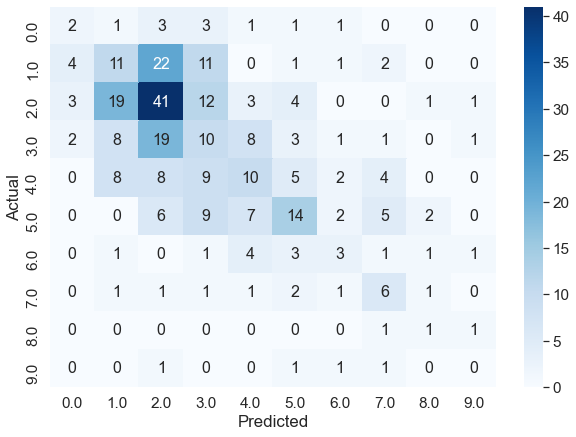

In [20]:
filename = f'./models/{nb_long_id}_rf_model_results_f{topN}.pkl'
print(filename)
rf, rf_score, rf_cm = pickle.load(open(filename,'rb'))

rf_y_pred = rf.predict(X_test)
rf_score = get_sk_metrics(y_test, rf_y_pred, average='macro')
rf_cm = plot_confusion_matrix(y_test, rf_y_pred)

In [21]:
X_test_scaled = AtPsy_X_test_scaled
rf_y_pred = rf.predict(X_test_scaled)

filename = f"../results/03_At/prediction/{nb_long_id}_rf_test_AtPsy_predict_f{topN}.pkl"
pickle.dump(rf_y_pred, open(filename, 'wb'))
print(f"Written to: {filename}")
rf_y_pred

Written to: ../results/03_At/prediction/03a05_At_nfd_rf_test_AtPsy_predict_f100.pkl


array([5., 5., 5., 5., 4., 7., 5., 7., 5., 5., 4., 4., 5., 5., 5., 5., 7.,
       5., 4., 5., 5., 5., 7., 5., 5., 5., 5., 5., 7., 7., 4., 5., 5., 5.,
       4., 5., 4., 5., 5., 5., 5., 4., 5., 5., 5., 7., 5., 5., 5., 5., 5.,
       5., 4., 5., 5., 4., 5., 4., 5., 5., 5., 5., 5., 5., 5., 7., 7., 3.,
       5., 5., 5., 5., 5., 7., 5., 5., 7., 5., 5., 5., 5., 5., 5., 7., 4.,
       7., 7., 5., 5., 4., 5., 5., 7., 7., 7., 5., 5., 3., 4., 4.])

## SVM
### RBF kernel
#### Train

In [22]:
#Create a svm Classifier
svm = SVC() 

t0 = time.time()
svm.fit(X_train, y_train)
t = time.time() - t0

print(f"\nelapsed time: {(t/60):.2f} mins")
print()


elapsed time: 0.01 mins



#### Test1

Accuracy:	 24.09%
Precision:	 17.84%
Recall:		 18.23%
F1 score:	 17.83%
Written to: ./models/03a05_At_nfd_svm_model_results_f100.pkl


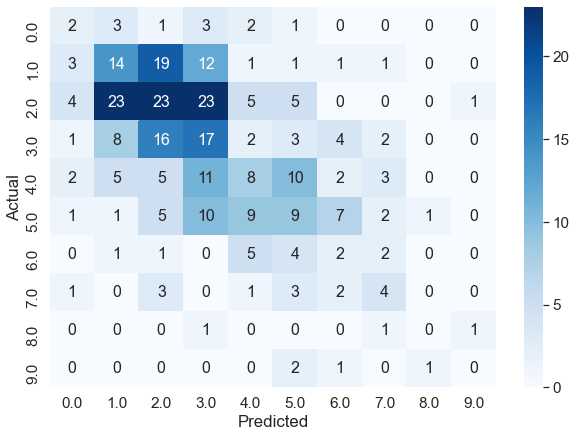

In [23]:
#Predict the response for test dataset
svm_y_pred = svm.predict(X_test)
svm_score = get_sk_metrics(y_test, svm_y_pred, average='macro')
svm_cm = plot_confusion_matrix(y_test, svm_y_pred)

filename = f"./models/{nb_long_id}_svm_model_results_f{topN}.pkl"
pickle.dump([svm, svm_score, svm_cm], open(filename, 'wb'))
print(f"Written to: {filename}")

#### Test2

In [24]:
#Predict the response for test dataset
svm_y_pred = svm.predict(At_X_test_scaled)

filename = f"../results/03_At/prediction/{nb_long_id}_svm_test_predict_f{topN}.pkl"
pickle.dump(svm_y_pred, open(filename, 'wb'))
print(f"Written to: {filename}")
svm_y_pred

Written to: ../results/03_At/prediction/03a05_At_nfd_svm_test_predict_f100.pkl


array([2., 2., 2., 2., 2., 2.])

### Test3 AtPsy

./models/03a05_At_nfd_svm_model_results_f100.pkl
Accuracy:	 24.09%
Precision:	 17.84%
Recall:		 18.23%
F1 score:	 17.83%


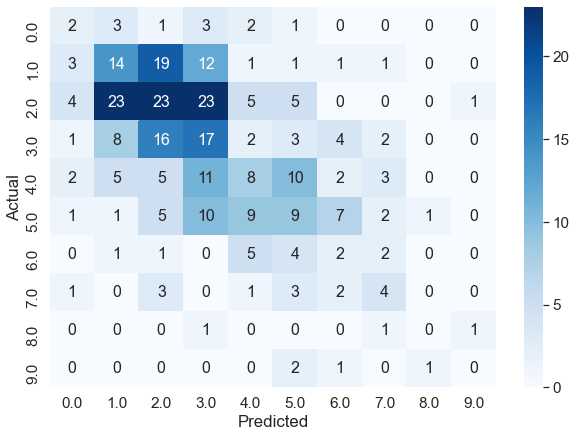

In [25]:
filename = f'./models/{nb_long_id}_svm_model_results_f{topN}.pkl'
print(filename)
svm, svm_score, svm_cm = pickle.load(open(filename,'rb'))

svm_y_pred = svm.predict(X_test)
svm_score = get_sk_metrics(y_test, svm_y_pred, average='macro')
svm_cm = plot_confusion_matrix(y_test, svm_y_pred)

In [26]:
#Predict the response for test dataset

X_test_scaled = AtPsy_X_test_scaled
svm_y_pred = svm.predict(X_test_scaled)

filename = f"../results/03_At/prediction/{nb_long_id}_svm_test_AtPsy_predict_f{topN}.pkl"
pickle.dump(svm_y_pred, open(filename, 'wb'))
print(f"Written to: {filename}")
svm_y_pred

Written to: ../results/03_At/prediction/03a05_At_nfd_svm_test_AtPsy_predict_f100.pkl


array([2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 3., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.])

### Linear kernel
#### Train

In [27]:
#Create a svm Classifier
svm_lin = SVC(kernel='linear') # Linear Kernel

t0 = time.time()
#Train the model using the training sets
svm_lin.fit(X_train, y_train)
t = time.time() - t0

print(f"\nelapsed time: {(t/60):.2f} mins")
print()


elapsed time: 0.01 mins



#### Test1

Accuracy:	 25.61%
Precision:	 25.72%
Recall:		 20.59%
F1 score:	 22.04%
Written to: ./models/03a05_At_nfd_svm_lin_model_results_f100.pkl


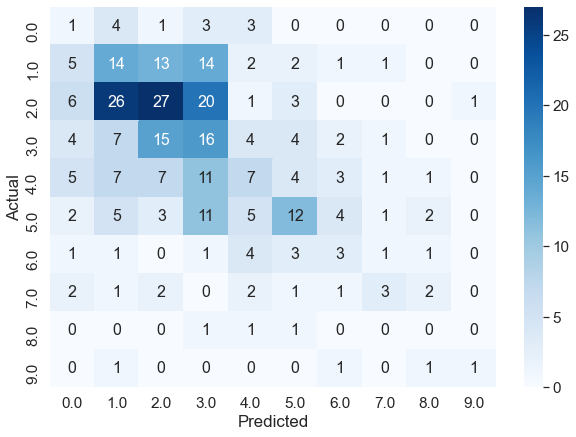

In [28]:
svm_lin_y_pred = svm_lin.predict(X_test)
svm_lin_score = get_sk_metrics(y_test, svm_lin_y_pred, average='macro')
svm_lin_cm = plot_confusion_matrix(y_test, svm_lin_y_pred)

filename = f"./models/{nb_long_id}_svm_lin_model_results_f{topN}.pkl"
pickle.dump([svm_lin, svm_lin_score, svm_lin_cm], open(filename, 'wb'))
print(f"Written to: {filename}")

#### Test2

In [29]:
svm_lin_y_pred = svm_lin.predict(At_X_test_scaled)

filename = f"../results/03_At/prediction/{nb_long_id}_svm_lin_test_predict_f{topN}.pkl"
pickle.dump(svm_lin_y_pred, open(filename, 'wb'))
print(f"Written to: {filename}")
svm_lin_y_pred

Written to: ../results/03_At/prediction/03a05_At_nfd_svm_lin_test_predict_f100.pkl


array([0., 1., 1., 0., 0., 0.])

### Test3 AtPsy

./models/03a05_At_nfd_svm_lin_model_results_f100.pkl
Accuracy:	 25.61%
Precision:	 25.72%
Recall:		 20.59%
F1 score:	 22.04%


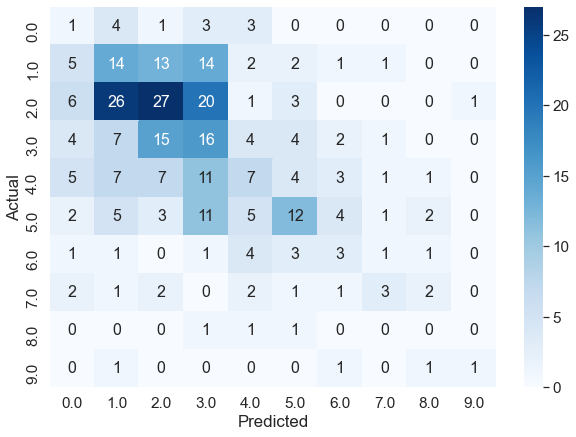

In [30]:
filename = f'./models/{nb_long_id}_svm_lin_model_results_f{topN}.pkl'
print(filename)
svm_lin, svm_lin_score, svm_lin_cm = pickle.load(open(filename,'rb'))

svm_lin_y_pred = svm_lin.predict(X_test)
svm_lin_score = get_sk_metrics(y_test, svm_lin_y_pred, average='macro')
svm_lin_cm = plot_confusion_matrix(y_test, svm_lin_y_pred)

In [31]:
X_test_scaled = AtPsy_X_test_scaled

svm_lin_y_pred = svm_lin.predict(X_test_scaled)

filename = f"../results/03_At/prediction/{nb_long_id}_svm_lin_test_AtPsy_predict_f{topN}.pkl"
pickle.dump(svm_lin_y_pred, open(filename, 'wb'))
print(f"Written to: {filename}")
svm_lin_y_pred

Written to: ../results/03_At/prediction/03a05_At_nfd_svm_lin_test_AtPsy_predict_f100.pkl


array([0., 6., 0., 0., 5., 6., 5., 6., 0., 0., 0., 0., 8., 0., 5., 6., 0.,
       0., 0., 0., 8., 6., 8., 0., 1., 0., 0., 0., 8., 6., 6., 8., 0., 6.,
       0., 6., 0., 0., 0., 5., 6., 5., 0., 0., 0., 5., 5., 5., 0., 0., 0.,
       0., 5., 6., 8., 5., 6., 5., 0., 5., 0., 5., 4., 0., 6., 6., 6., 6.,
       6., 6., 6., 0., 6., 6., 6., 0., 5., 5., 8., 0., 5., 8., 0., 8., 5.,
       8., 1., 0., 0., 5., 8., 6., 6., 0., 5., 5., 0., 4., 5., 5.])

## Plots
### Performance metrics

**Precision** is a measure of the ability of a classification model to identify only the relevant data points.<br>
**Recall** is a measure of the ability of a model to find all the relevant cases within a dataset.

Saving to ./figures/03a05_At_nfd_score_f100.pdf



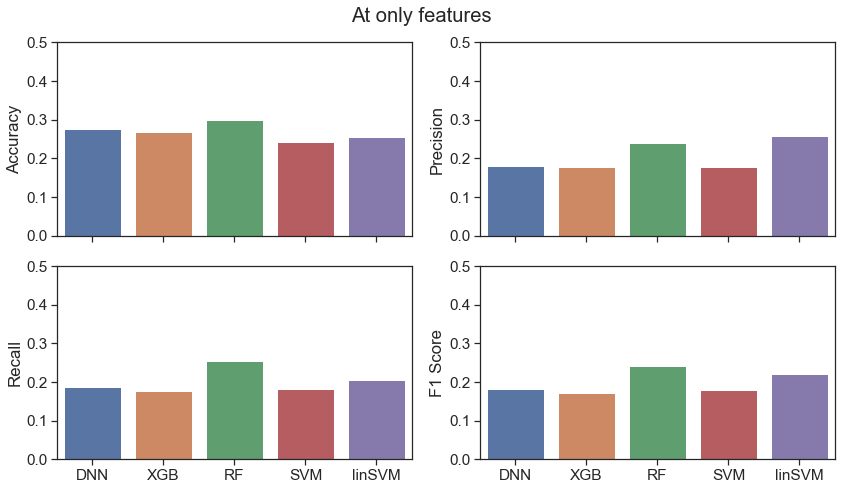

,Accuracy,Precision,Recall,F1 Score
DNN,0.274390,0.181029,0.187163,0.182575
XGB,0.268293,0.176657,0.175956,0.172500
RF,0.298780,0.239908,0.254539,0.241020
SVM,0.240854,0.178445,0.182342,0.178297
linSVM,0.256098,0.257181,0.205901,0.220406


In [32]:
max_ylim = 0.5
file_out = f'./figures/{nb_long_id}_score_f{topN}.pdf'
fig_title = 'At only features'
df_metrics = plot_performance_metrics(nb_long_id, max_ylim, file_out, fig_title, feature_size=topN)
df_metrics

#### Fuzzy results

Saving to ./figures/03a05_At_nfd_fuzzy_score_f100.pdf



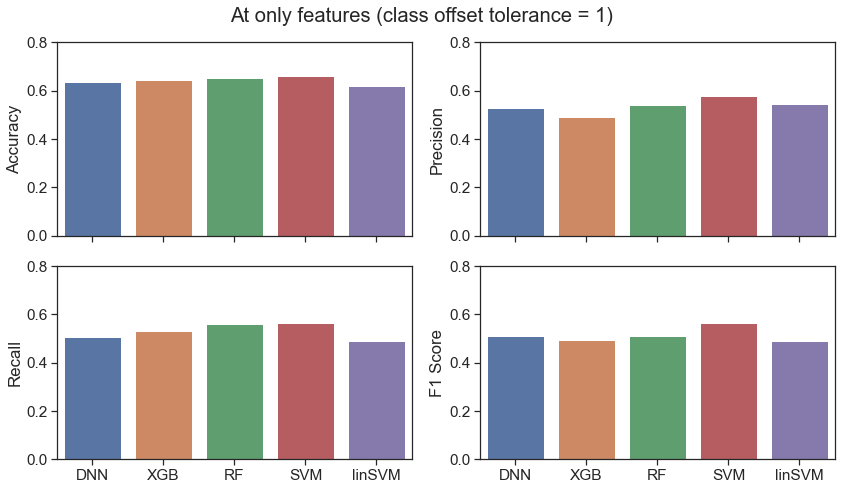

,Accuracy,Precision,Recall,F1 Score
DNN,0.634146,0.526842,0.504431,0.509887
XGB,0.643293,0.489703,0.529680,0.493673
RF,0.652439,0.539020,0.558774,0.508542
SVM,0.658537,0.576791,0.565534,0.565106
linSVM,0.618902,0.546361,0.490164,0.491835


In [33]:
max_ylim = 0.8
offset = 1
file_out = f'./figures/{nb_long_id}_fuzzy_score_f{topN}.pdf'
fig_title = f'At only features (class offset tolerance = {offset})'
df_metrics = plot_performance_metrics(nb_long_id, max_ylim, file_out, fig_title, offset, feature_size=topN)
df_metrics

### MSE

Saving to ./figures/03a05_At_nfd_mse_f100.pdf



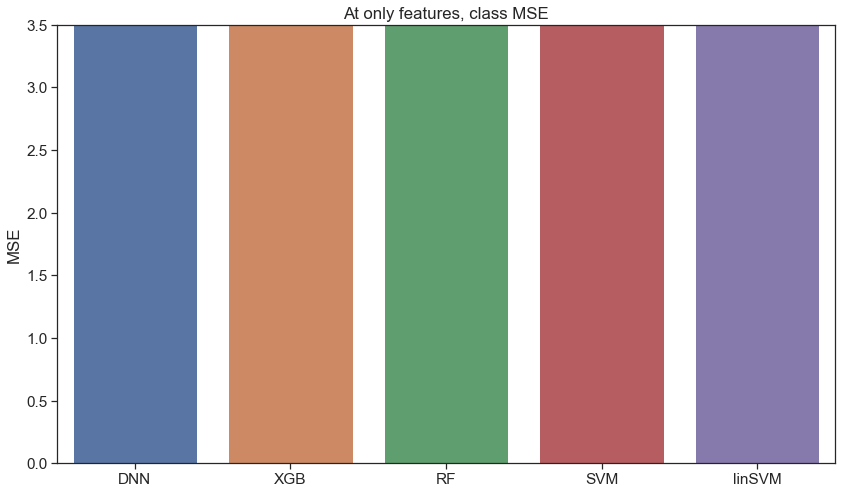

,MSE
DNN,3.579268
XGB,3.515244
RF,3.560976
SVM,3.527439
linSVM,4.368902


In [34]:
total_class_mse, class_mse, class_rss = class_error(dnn_cm)
total_class_mse

max_ylim = 3.5
file_out = f'./figures/{nb_long_id}_mse_f{topN}.pdf'
fig_title = f'At only features, class MSE'
df_metrics = plot_mse(nb_long_id, max_ylim, file_out, fig_title, feature_size=topN)
df_metrics

### Test2 prediction summary

In [35]:
cols = ['DNN', 'XGB', 'RF', 'SVM', 'linSVM']
ml_predictions = np.vstack((dnn_y_pred, xgb_y_pred, rf_y_pred, svm_y_pred, svm_lin_y_pred)).T
df_test2_predict = pd.DataFrame(data=ml_predictions, columns=cols, )

print(f"{nb_long_id} Test Predictions")
filename = f"../results/03_At/prediction/{nb_long_id}_test_predictions_f{topN}.pkl"
pickle.dump(df_test2_predict, open(filename, 'wb'))
print(f"Written to: {filename}")

df_test2_predict

03a05_At_nfd Test Predictions
Written to: ../results/03_At/prediction/03a05_At_nfd_test_predictions_f100.pkl


,DNN,XGB,RF,SVM,linSVM
0,5.0,2.0,5.0,2.0,0.0
1,4.0,2.0,5.0,2.0,6.0
2,4.0,2.0,5.0,2.0,0.0
3,2.0,2.0,5.0,2.0,0.0
4,5.0,2.0,4.0,2.0,5.0
...,...,...,...,...,...
95,5.0,2.0,5.0,2.0,5.0
96,4.0,2.0,5.0,2.0,0.0
97,4.0,2.0,3.0,2.0,4.0
98,5.0,2.0,4.0,2.0,5.0


### Test3 prediction summary

In [36]:
cols = ['DNN', 'XGB', 'RF', 'SVM', 'linSVM']
ml_predictions = np.vstack((dnn_y_pred, xgb_y_pred, rf_y_pred, svm_y_pred, svm_lin_y_pred)).T
df_test3_predict = pd.DataFrame(data=ml_predictions, columns=cols, )

print(f"{nb_long_id} Test Predictions")
filename = f"../results/03_At/prediction/{nb_long_id}_test_AtPsy_predictions_f{topN}.pkl"
pickle.dump(df_test3_predict, open(filename, 'wb'))
print(f"Written to: {filename}")

df_test3_predict

03a05_At_nfd Test Predictions
Written to: ../results/03_At/prediction/03a05_At_nfd_test_AtPsy_predictions_f100.pkl


,DNN,XGB,RF,SVM,linSVM
0,5.0,2.0,5.0,2.0,0.0
1,4.0,2.0,5.0,2.0,6.0
2,4.0,2.0,5.0,2.0,0.0
3,2.0,2.0,5.0,2.0,0.0
4,5.0,2.0,4.0,2.0,5.0
...,...,...,...,...,...
95,5.0,2.0,5.0,2.0,5.0
96,4.0,2.0,5.0,2.0,0.0
97,4.0,2.0,3.0,2.0,4.0
98,5.0,2.0,4.0,2.0,5.0


## Others

In [37]:
topN = 10
df = get_prediction_df(nb_long_id, feature_size=topN)
print(f"{nb_long_id}_{topN} Test Predictions")
df

03a05_At_nfd_10 Test Predictions


,dnn,xgb,rf,svm,svm_lin
0,4.0,4.0,4.0,2.0,6.0
1,6.0,3.0,5.0,6.0,6.0
2,4.0,4.0,4.0,4.0,6.0
3,6.0,3.0,3.0,3.0,8.0
4,5.0,5.0,5.0,5.0,6.0
5,6.0,3.0,3.0,3.0,6.0


In [38]:
topN = 50
df = get_prediction_df(nb_long_id, feature_size=topN)
print(f"{nb_long_id}_{topN} Test Predictions")
df

03a05_At_nfd_50 Test Predictions


,dnn,xgb,rf,svm,svm_lin
0,2.0,2.0,2.0,2.0,0.0
1,2.0,2.0,2.0,2.0,1.0
2,2.0,2.0,2.0,2.0,2.0
3,5.0,3.0,3.0,3.0,3.0
4,1.0,2.0,5.0,2.0,3.0
5,4.0,3.0,5.0,3.0,3.0


In [39]:
topN = 100
df = get_prediction_df(nb_long_id, feature_size=topN)
print(f"{nb_long_id}_{topN} Test Predictions")
df

03a05_At_nfd_100 Test Predictions


,dnn,xgb,rf,svm,svm_lin
0,4.0,2.0,2.0,2.0,0.0
1,1.0,2.0,4.0,2.0,1.0
2,1.0,2.0,2.0,2.0,1.0
3,5.0,2.0,5.0,2.0,0.0
4,5.0,2.0,5.0,2.0,0.0
5,5.0,2.0,5.0,2.0,0.0


In [40]:
topN = 3000
df = get_prediction_df(nb_long_id, feature_size=topN)
print(f"{nb_long_id}_{topN} Test Predictions")
df

03a05_At_nfd_3000 Test Predictions


,dnn,xgb,rf,svm,svm_lin
0,2.0,3.0,2.0,2.0,2.0
1,1.0,1.0,1.0,2.0,1.0
2,1.0,1.0,2.0,2.0,1.0
3,3.0,3.0,3.0,3.0,3.0
4,3.0,3.0,4.0,3.0,3.0
5,3.0,5.0,5.0,3.0,3.0
